In [47]:
#importing libraries for part 1 
import pandas as pd
import numpy as np
import pycountry
import os
import seaborn as sns
from helper_functions import load_ratings, load_breweries, load_users, add_user_and_brewery_location, drop_breweries_with_less_than_n_reviews, get_average_rating_and_count_per_brewery, get_average_per_country, plot_world_map, drop_countries_with_less_than_n_reviews, keep_only_countries_in_list_and_merge_all_dfs
import matplotlib.pyplot as plt

#importing libraries for part 2 
from scipy import stats
from geopy.geocoders import Nominatim
import random
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

#importing libraries for part 3 
from statsmodels.tsa.stattools import adfuller
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from transformers import pipeline, TFAutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt


# Question 1: Where are the beer nations?

In [48]:
#Dataset directories
ROOT_DIR = os.path.abspath(os.curdir)
DATA_DIR = os.path.join(ROOT_DIR, 'data/')
BA_DIR = os.path.join(DATA_DIR, 'BeerAdvocate/')
RB_DIR = os.path.join(DATA_DIR, 'RateBeer/')
MATCHED_BEER_DIR = os.path.join(DATA_DIR, "matched_beer_data/")

In [49]:
#Dataset loading
ratings_data = load_ratings(os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_rb.txt'), os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_ba.txt'))
breweries_data = load_breweries(os.path.join(RB_DIR, 'breweries.csv'), os.path.join(BA_DIR, 'breweries.csv'))
users_data = load_users(os.path.join(RB_DIR, 'users.csv'), os.path.join(BA_DIR, 'users.csv'))
breweries_data['id'] = breweries_data['id'].astype(int)
ratings_data['brewery_id'] = ratings_data['brewery_id'].astype(int)
ratings_data['beer_id'] = ratings_data['beer_id'].astype(int)

In [50]:
brewery_id_to_country = breweries_data.set_index("id")["location"].to_dict()
beer_id_to_brewery_id = ratings_data.set_index("beer_id")["brewery_id"].to_dict()
beer_country_dict = {}
for beer_id, brewery_id in beer_id_to_brewery_id.items():
    if brewery_id in brewery_id_to_country:
        country = brewery_id_to_country[brewery_id]
        beer_country_dict[beer_id] = country

In [51]:
count_reviews = ratings_data.groupby(['beer_id'])['rating'].count().to_frame().reset_index().rename(columns={'rating': 'count'})
count_reviews["country"] = count_reviews['beer_id'].map(brewery_id_to_country)

In [52]:
count_rating_per_country = count_reviews.groupby('country')['count'].sum().reset_index()

In [53]:
ratings_data['country'] = ratings_data['beer_id'].map(beer_country_dict)

# Let's investigate Beer nations
The concept of "Beer Nations" can be explored by examining countries with a high number of breweries and a diverse range of beer styles. Typically, countries like Belgium, Germany, and the United States are renowned for their beer culture.
By analyzing the distribution of breweries and the variety of beer styles, we will identify which countries stand out as prominent beer producers and connoisseurs.

In [54]:
ratings_copy = ratings_data.copy()

In [55]:
# Grouping by country to count breweries and styles
beer_nations_df = ratings_copy.groupby('country').agg(
    Brewery_Count=('beer_id', 'nunique'),
    Style_Diversity=('style', 'nunique')
).reset_index()

In [56]:
top_brewery_countries = beer_nations_df.nlargest(10, 'Brewery_Count')

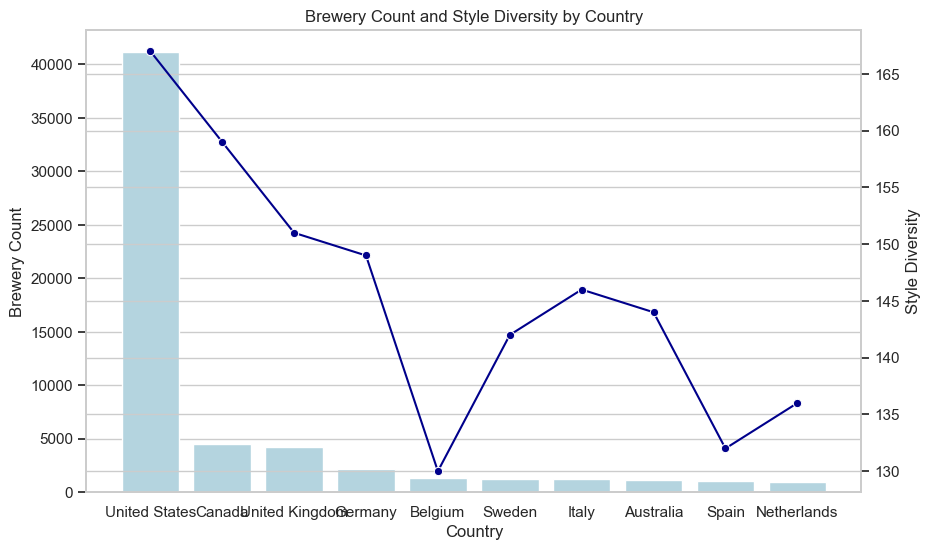

In [57]:
sns.set(style="whitegrid")

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Brewery Count
sns.barplot(x='country', y='Brewery_Count', data=top_brewery_countries, ax=ax1, color='lightblue')

# Line plot for Style Diversity
ax2 = ax1.twinx()
sns.lineplot(x='country', y='Style_Diversity', data=top_brewery_countries, ax=ax2, color='darkblue', marker='o')

ax1.set_title('Brewery Count and Style Diversity by Country')
ax1.set_xlabel('Country')
ax1.set_ylabel('Brewery Count')
ax2.set_ylabel('Style Diversity')

plt.show()

The United States leads significantly in brewery count (41,152) and style diversity (167). This suggests a highly developed and diverse beer industry, likely offering a wide range of beer experiences from mass-produced to craft and specialty beers.
Belgium and Germany, known for their beer culture, show a good balance of brewery count and style diversity (Belgium: 1,369 breweries, 130 styles; Germany: 2,131 breweries, 149 styles). This aligns with their reputation for quality and variety in beer production.
High brewery count and style diversity in countries like Canada and the UK also indicate thriving beer industries. The data reveals a correlation between a country's beer culture's maturity and its diversity in beer styles.

# Now let's look at the ratings by country
Some countries might excel in specific aspects, like the robust taste profiles of Belgian ales or the refined appearance of German lagers. This analysis will help in understanding which countries' beers are most favored by enthusiasts and critics alike.

In [58]:
ratings_copy = ratings_data.copy()

In [59]:
ratings_by_country_df = ratings_copy.groupby('country').agg(
    Average_Taste_Rating=('taste', 'mean'),
    Average_Aroma_Rating=('aroma', 'mean'),
    Average_Appearance_Rating=('appearance', 'mean'),
    Average_Palate_Rating=('palate', 'mean'),
    Average_Overall_Rating=('rating', 'mean')
).reset_index()

In [60]:
top_rated_countries = ratings_by_country_df.nlargest(10, 'Average_Overall_Rating')

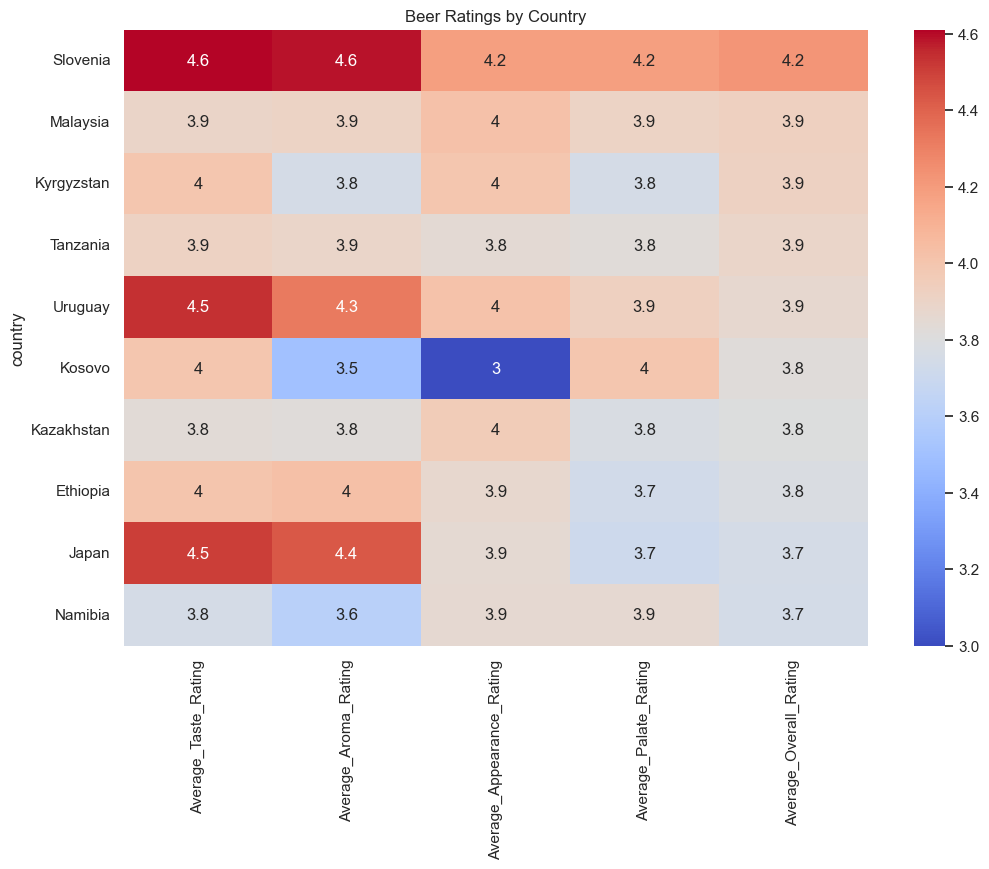

In [61]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(top_rated_countries.set_index('country'), annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Beer Ratings by Country')
plt.show()

Slovenia, with high average ratings across taste, aroma, appearance, palate, and overall (around 4.6 for taste and aroma), suggests an exceptionally high quality of beer, potentially indicating a niche, high-quality beer market.
Japan's high ratings (average taste rating of 4.5) indicate a preference for quality and unique flavors in their beer industry.
The presence of countries like Malaysia and Tanzania with higher-than-expected ratings might suggest emerging markets with developing tastes or unique local beer styles gaining popularity.

# Let's now analyse the popular beer styles by country
The results might reflect traditional preferences, like the popularity of stouts in Ireland or IPAs in the United States, or could uncover emerging trends in global beer tastes.

In [62]:
ratings_copy = ratings_data.copy()

In [63]:
# Calculate the average rating and review count for each style
style_popularity = ratings_copy.groupby('style').agg(
    Average_Rating=('rating', 'mean'),
    Review_Count=('rating', 'count')
).reset_index()

# Select the top N styles based on review count or rating
N_styles = 10
top_styles = style_popularity.nlargest(N_styles, 'Review_Count')['style']

# Filter the original dataframe to include only the top styles
filtered_styles_df = ratings_copy[ratings_copy['style'].isin(top_styles)]

In [64]:
# Assuming 'popular_styles_df' has columns 'country' and 'rating'
top_countries = ratings_copy.groupby('country').size().nlargest(10).index

filtered_df = filtered_styles_df[filtered_styles_df['country'].isin(top_countries)]

# Group by country and style to find the most popular style in each country
country_style_popularity = filtered_df.groupby(['country', 'style']).agg(
    Average_Rating=('rating', 'mean'),
    Review_Count=('rating', 'count')
).reset_index()

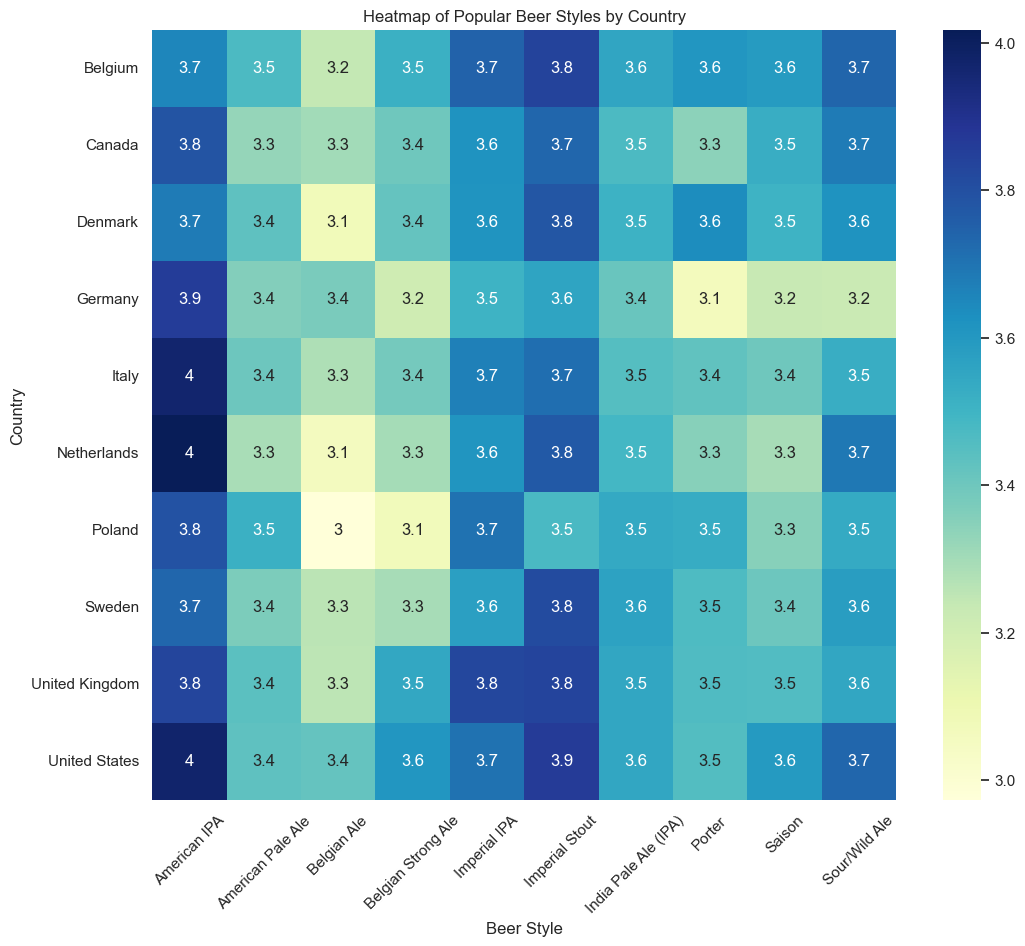

In [65]:
# Creating a pivot table for visualization
pivot_table = country_style_popularity.pivot_table(index='country', columns='style', values='Average_Rating')

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Popular Beer Styles by Country')
plt.ylabel('Country')
plt.xlabel('Beer Style')
plt.xticks(rotation=45)
plt.show()

The United States shows a diverse range of popular beer styles with high ratings, especially for American IPA (average rating of 3.98) and Imperial Stout (3.86). This diversity reflects the dynamic and innovative nature of the American beer market.
The UK and Belgium also show diversity in popular styles, with high ratings in categories like Imperial Stout and Belgian Strong Ale, reflecting their traditional strengths.
The data reflects a blend of traditional and modern styles, indicating a global trend towards variety and experimentation in beer production.

# Finally, let's try to find a correlation between breweries, diversity and ranking
An analysis of the correlation between the number of breweries, diversity of beer types, and overall beer ratings in each country is an insightful undertaking. This involves examining whether countries with more breweries and a wider range of beer styles tend to have higher overall ratings for their beers. Such a correlation, if present, could suggest that a vibrant, competitive brewing scene fosters higher quality and innovation in beer production.

In [66]:
ratings_copy = ratings_data.copy()

In [67]:
correlation_df = ratings_copy.groupby('country').agg(
    Brewery_Count=('beer_id', 'nunique'),
    Style_Diversity=('style', 'nunique'),
    Average_Overall_Rating=('rating', 'mean')
).reset_index()

In [68]:
top_correlation_countries = correlation_df[correlation_df['country'].isin(top_brewery_countries['country'])]

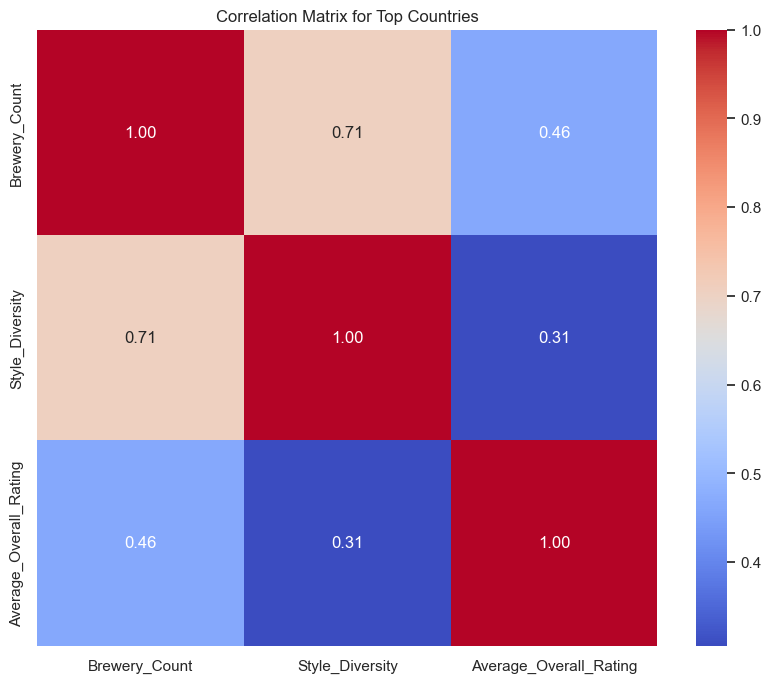

In [69]:
# Exclude non-numeric columns (like 'country') before calculating the correlation
numeric_cols = top_correlation_countries.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix on numeric columns only
corr_matrix = numeric_cols.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Top Countries')
plt.show()

Correlation Between Brewery Count and Style Diversity: 
The correlation coefficient is 0.707. This is a strong positive correlation, suggesting that countries with more breweries tend to also have a greater diversity of beer styles. This relationship implies that as the beer industry in a country expands in terms of the number of breweries, there is a parallel increase in the variety of beer styles produced. It indicates a thriving beer culture where expansion leads to innovation and variety.

Correlation Between Brewery Count and Average Overall Rating: 
The correlation coefficient is 0.464. This is a moderate positive correlation. It implies that countries with more breweries tend to have higher average overall ratings for their beers, although the relationship is not as strong as with style diversity. This could suggest that having more breweries contributes to better quality beers, possibly due to increased competition, a greater exchange of brewing techniques, or a wider selection for consumers.

Correlation Between Style Diversity and Average Overall Rating: 
The correlation coefficient is 0.306. This is a positive but relatively weak correlation. It indicates that a greater diversity of beer styles has some association with higher average overall ratings, but other factors may play a more significant role in determining beer quality. This could mean that simply having a wide variety of beer styles is not a strong predictor of overall beer quality as perceived by consumers or critics.

# Question 2 IBR - International beer relations

In [ ]:
#Dataset directories
ROOT_DIR = os.path.abspath(os.curdir)
DATA_DIR = os.path.join(ROOT_DIR, 'data/')
BA_DIR = os.path.join(DATA_DIR, 'BeerAdvocate/')
RB_DIR = os.path.join(DATA_DIR, 'RateBeer/')
MATCHED_BEER_DIR = os.path.join(DATA_DIR, "matched_beer_data/")

In [ ]:
#Dataset loading
ratings_data = load_ratings(os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_rb.txt'), os.path.join(MATCHED_BEER_DIR, 'ratings_with_text_ba.txt'))
breweries_data = load_breweries(os.path.join(RB_DIR, 'breweries.csv'), os.path.join(BA_DIR, 'breweries.csv'))
users_data = load_users(os.path.join(RB_DIR, 'users.csv'), os.path.join(BA_DIR, 'users.csv'))

In this section we will take a closer look at geography of beer, to find out which geographical factor affect the reviews and ratings of beer.  This section is divided into four sections:
1. From which countries do the majority of ratings for each nation's beers originate?
2. Which country’s beers are particularly popular abroad?
3. Is there a Beer Union with countries that are mutually enthusiastic about their beer?
4. Is there a domestic beer pride? Do users rate beers brewed in their home country better or worse?

## From which countries do the majority of ratings for each nation's beers originate?

To begin to answer this question, we are going to need to do a bit of data cleaning and preparing

This Python function `add_user_and_brewery_locations` processes dataframes to add location information, split ratings into local and international, and returns the results.

In [191]:
def add_user_and_brewery_locations(ratings, users, breweries):
    # Create dictionaries for user and brewery locations
    users_location_dict = {user_id: location for user_id, location in zip(users['user_id'], users['location'])}
    breweries_location_dict = {brewery_id: location for brewery_id, location in zip(breweries['id'], breweries['location'])}

    # Make a copy of the ratings dataframe
    ratings_final = ratings.copy()

    # Convert user_id and brewery_id to strings
    ratings_final['user_id'] = ratings_final['user_id'].astype(str)
    ratings_final['brewery_id'] = ratings_final['brewery_id'].astype(str)

    # Map brewery and user locations to the ratings dataframe
    ratings_final['brewery_location'] = ratings_final['brewery_id'].map(breweries_location_dict)
    ratings_final['user_location'] = ratings_final['user_id'].map(users_location_dict)

    # Split ratings into local and international based on location
    ratings_local = ratings_final[ratings_final['brewery_location'] == ratings_final['user_location']]
    ratings_international = ratings_final[ratings_final['brewery_location'] != ratings_final['user_location']]

    return ratings_final, ratings_local, ratings_international

ratings, local_ratings, international_ratings = add_user_and_brewery_location(ratings_data, users_data, breweries_data)

Let's take a closer look at the result:

In [194]:

ratings.head(5)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,brewery_location,user_location
0,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1429178400,ciaranc,151109,3,7,2,8,17,3.70,"Bottle, gift from Aaron. Black, big head, lots...",NaN,United Kingdom,Ireland
1,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1427796000,Rowlymo,198957,4,7,4,8,15,3.80,500ml Bottle in Bittles bar Belfast. Chocolate...,NaN,United Kingdom,nan
2,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1421665200,Don2711,285162,4,8,5,7,17,4.10,Great one and made very local to me. Bottle bo...,NaN,United Kingdom,nan
3,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1380621600,genegenie,224156,5,8,3,5,19,4.00,"Deep roasted aroma, good dark brown/black colo...",NaN,United Kingdom,United Kingdom
4,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1371549600,kiwianer,88501,4,7,4,7,14,3.60,"The head is medium, the body black. It smells ...",NaN,United Kingdom,New Zealand


By looking at the data, we notice missing information about the user's locations, this is understandable as I myself would not freely give out this information on an online forum, to proceed, we will need to handle these missing values as we continue. Let's now find the top 10 brewery countries with the most ratings to look at, and from there find the top 3 user locations of reviews per brewery country.

In [101]:
# Combining ratings from different sources
combined_ratings = pd.concat([local_ratings, international_ratings])

# Counting ratings by user and brewery location
rating_sources = combined_ratings.groupby(['brewery_location', 'user_location']).size().reset_index(name='rating_count')

# Filtering out unspecified user locations ('nan')
rating_sources_filtered = rating_sources[rating_sources['user_location'] != 'nan']

# Sorting and summarizing ratings per brewery's country
rating_counts_per_brewery_country = rating_sources_filtered.groupby('brewery_location').sum().reset_index().sort_values(by='rating_count', ascending=False)

# Picking the top 10 brewery countries with the most ratings
top_10_brewery_countries = rating_counts_per_brewery_country.head(10)['brewery_location']

# Narrowing it down to those top 10 countries
top_10_rating_sources = rating_sources_filtered[rating_sources_filtered['brewery_location'].isin(top_10_brewery_countries)]

# Finding the major sources of ratings for each of the top 10 countries
top_10_sources_analysis = top_10_rating_sources.sort_values(['brewery_location', 'rating_count'], ascending=[True, False])
top_10_sources_per_brewery = top_10_sources_analysis.groupby('brewery_location').head(3)

top_10_sources_per_brewery  # Checking out the results

,brewery_location,user_location,rating_count
293,Belgium,United States,51241
208,Belgium,Belgium,11702
224,Belgium,Denmark,10349
448,Canada,Canada,46059
507,Canada,United States,14751
455,Canada,Denmark,629
769,Denmark,Denmark,14690
812,Denmark,Sweden,4175
819,Denmark,United States,3968
1227,Germany,United States,25819


We immediately notice that the United states is one of the top 3 sources of user reviews for every country except poland, this indicates a data skew. The four most common type of ratings are:
1. United states users rating United States beer (472769)
2. United states users rating Belgian beer (51241)
3. Canadian users rating Canadian beer (46059)
4. United Kingdom Users rating United Kingdom beer (3223)

From this we can see that in general most reviews for each brewery comes from users of the same country as that brewery. This makes intuitive sense as we would expect that domestic users have more access to domestic beer. However, given the nature of how skewed the data is toward United States users, there are exceptions where for example it seems that there are more United users reviewing Belgium beer than Belgium users. This does not indicate that Belgium beer is prodominantly drank by United States citizens, but rather a more likely explanation is that there are more United States review website users than Belgium users.

Let's visualize the results on a map.

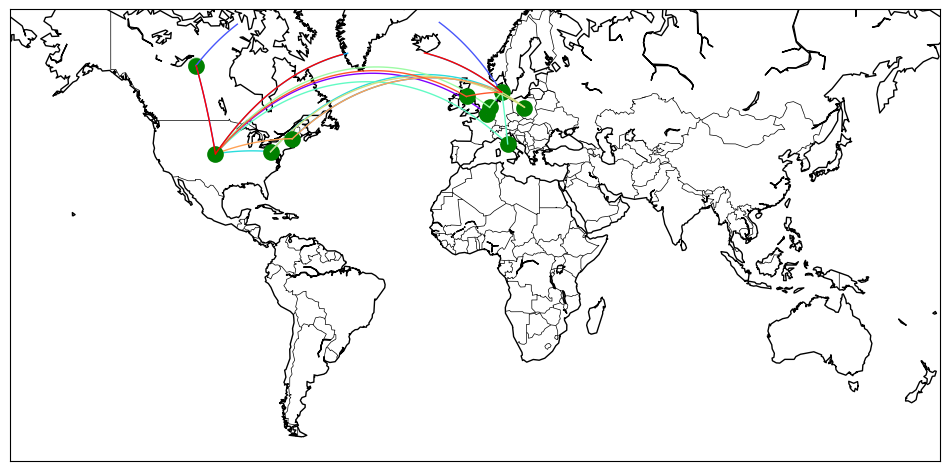

In [52]:
# Combining location data with maps
geolocator = Nominatim(user_agent="geoapiExercises")

# Adding randomness to latitudes and longitudes
def get_lat_lon(location, offset=0.05):
    try:
        loc = geolocator.geocode(location)
        lat = loc.latitude + random.uniform(-offset, offset)
        lon = loc.longitude + random.uniform(-offset, offset)
        return (lat, lon)
    except:
        return (None, None)

def draw_map(dataframe):
    # Creating a large map
    plt.figure(figsize=(12, 8))
    m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

    # Drawing coastlines and countries
    m.drawcoastlines()
    m.drawcountries()

    # Picking colors for breweries
    brewery_locations = dataframe['brewery_location'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(brewery_locations)))

    # Looping through data
    for index, row in dataframe.iterrows():
        brewery_loc = row['brewery_location']
        user_loc = row['user_location']
        rating_count = row['rating_count']

        lat_brewery, lon_brewery = get_lat_lon(brewery_loc)
        lat_user, lon_user = get_lat_lon(user_loc)

        if lat_brewery and lon_brewery and lat_user and lon_user:
            x_brewery, y_brewery = m(lon_brewery, lat_brewery)
            x_user, y_user = m(lon_user, lat_user)

            # Adjusting arrow width based on ratings
            arrow_width = np.clip(1 / 10000, 1, 5)

            # Plotting a green circle for same-location brews
            if brewery_loc == user_loc:
                m.plot(x_brewery, y_brewery, 'o', markersize=10, color='green', markeredgewidth=2)
                m.tissot(lon_brewery, lat_brewery, 1.5, 100, facecolor='green', alpha=0.4)
            else:
                # Matching colors to brewery locations
                color = colors[np.where(brewery_locations == brewery_loc)[0][0]]

                # Drawing arrows from brewery to user
                m.drawgreatcircle(lon_brewery, lat_brewery, lon_user, lat_user, linewidth=arrow_width, color=color)

    # Displaying the map without a legend
    plt.show()

# Visualizing our map
draw_map(top_10_sources_per_brewery)


# Which country’s beers are particularly popular abroad?

### International review count and proportion


To address this question, we will first we take a look at the countries with the highest number of reviews and we compare that with countries with the highest number of reviews from abroad and see if there are any proportinal differences

In [108]:
# Group by brewery location and user location, then count the ratings
rating_sources_international = international_ratings.groupby(['brewery_location', 'user_location']).size().reset_index(name='rating_count')

# Filter out rows where 'user_location' is not the string 'nan'
rating_sources_filtered_international = rating_sources_international[rating_sources_international['user_location'] != 'nan']

# Sort and count ratings for each brewery country
rating_counts_per_brewery_country_international = rating_sources_filtered_international.groupby('brewery_location').sum().reset_index().sort_values(by='rating_count', ascending=False)

most_reviewed_countries_international = rating_counts_per_brewery_country_international.drop(columns=['user_location'])
most_reviewed_countries_international.head(10)

,brewery_location,rating_count
10,Belgium,116013
136,United States,90299
135,United Kingdom,69363
43,Germany,59965
31,Denmark,26968
59,Italy,22096
90,Netherlands,21398
121,Sweden,21390
19,Canada,20989
40,France,13162


It appears that most of the international reviews are reviews on Belgium beer, followed by the US and the UK respectively, however it would be insightful to also consider the proportion of international reviews compared to all reviews.

In [117]:
# Prepare data by removing 'user_location' for focus
most_reviewed_countries = rating_counts_per_brewery_country.drop(columns=['user_location'])

# Merge two DataFrames using 'brewery_location'
merged_df = pd.merge(
    most_reviewed_countries_international,
    most_reviewed_countries,
    on='brewery_location',
    suffixes=('_international', '_total')
)

# Calculate international review proportion
merged_df['proportion_international'] = merged_df['rating_count_international'] / merged_df['rating_count_total']

# Keep only brewery location and international proportion
merged_df = merged_df[['brewery_location', 'proportion_international']]

# Present the top 10 with the highest international proportions
merged_df.head(10).sort_values(by='proportion_international', ascending=False)


,brewery_location,proportion_international
9,France,0.912064
0,Belgium,0.908374
5,Italy,0.858831
3,Germany,0.819586
2,United Kingdom,0.682532
4,Denmark,0.647367
6,Netherlands,0.620016
7,Sweden,0.536978
8,Canada,0.313044
1,United States,0.160370


It appears that the none english speaking countries in general have a higher proportion of international beer reviews. This makes sense because the beer review dataset is made up of english reviews, so you would expect a high proportion of the reviews to originate from the United States, Canada and the United Kingdom, and indeed, despite the united states having significantly higher international rating counts than most countries besides belgium, the proportion of international beer reviews is the lowest of the bunch, this affirms that a high proportion of beer reviews originate from the United States. 



### International review ratings 

Another sense of the term "popular" beer is how liked the beers are abroad, let's assume that a higher rating of beer is correlated to being a liked beer, and use this assumption to find out which countries on average have the most liked beers.

In [195]:
# Calculate average rating and count per brewery
def get_average_rating_and_count_per_brewery(ratings):
    # Convert 'rating' to numeric, handling non-numeric values
    ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')

    # Calculate mean and count for each brewery
    ratings_by_brewery = ratings[['brewery_id', 'rating']]
    mean_ratings = ratings_by_brewery.groupby('brewery_id').mean().rename(columns={'rating': 'mean_rating'})
    count_ratings = ratings_by_brewery.groupby('brewery_id').count().rename(columns={'rating': 'count'})

    # Merge mean and count
    average_and_count = pd.merge(mean_ratings, count_ratings, on='brewery_id')

    # Merge with the original ratings to get brewery locations
    average_and_count = pd.merge(average_and_count, ratings[['brewery_id', 'brewery_location']].drop_duplicates(), on='brewery_id')

    # Set type of count to int
    average_and_count['count'] = average_and_count['count'].astype(int)

    return average_and_count

# Filter out breweries with less than 'n' reviews
def drop_breweries_with_less_than_n_reviews(data, n):
    return data[data['count'] >= n]

# Calculate the average rating per country
def get_average_per_country(ratings):
    return ratings.groupby('brewery_location')['mean_rating'].mean().to_frame().sort_values(by='mean_rating', ascending=False).reset_index()

# Calculate review counts per country
def prepare_country_review_counts(ratings):
    # Count reviews per country
    return ratings.groupby('brewery_location').size().reset_index(name='count')

# Getting the average rating and count per brewery
average_rating_and_count = get_average_rating_and_count_per_brewery(international_ratings)

# Filtering out breweries with less than 'n' reviews (replace 'n' with your desired threshold)
filtered_data = drop_breweries_with_less_than_n_reviews(average_rating_and_count, n=10)

# Getting the average rating per country
average_per_country = get_average_per_country(filtered_data)


C:\Users\Christopher\AppData\Local\Temp\ipykernel_212408\2664948874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['rating'] = pd.to_numeric(ratings['rating'], errors='coerce')


In [ ]:
#Calling auxilliary functions to compute the average rating and count per brewery for international, local and overall ratings of the breweries.
average_and_count_per_brewery = get_average_rating_and_count_per_brewery(ratings)
local_average_and_count_per_brewery = get_average_rating_and_count_per_brewery(local_ratings)
international_average_and_count_per_brewery = get_average_rating_and_count_per_brewery(international_ratings)

# Drop breweries with less than 50 ratings to ignore small breweries, and with less than 10 ratings for local and international breweries for meaningful data
large_breweries_average_and_count = drop_breweries_with_less_than_n_reviews(average_and_count_per_brewery, 50)
local_large_breweries_average_and_count = drop_breweries_with_less_than_n_reviews(local_average_and_count_per_brewery, 10)
international_large_breweries_average_and_count = drop_breweries_with_less_than_n_reviews(international_average_and_count_per_brewery, 10)

In [74]:
#ratings average per country
average_per_country = get_average_per_country(large_breweries_average_and_count)
local_average_per_country = get_average_per_country(local_large_breweries_average_and_count)
international_average_per_country = get_average_per_country(international_large_breweries_average_and_count)

Taking a look at the international mean ratings for the top 10 countries, we find the following interesting results:

In [84]:
international_average_per_country.head(10)

,brewery_location,mean_rating
0,Malaysia,3.930000
1,Tanzania,3.885781
2,Belarus,3.862372
3,Ethiopia,3.791744
4,Uruguay,3.786667
5,Ecuador,3.771894
6,Nigeria,3.769881
7,Iran,3.768976
8,Pakistan,3.710682
9,Lebanon,3.695888


I am no beer conaisseur, but when I ask myself what the beer nations might be, I go to Belgium, Germany, Ireland, Japan the Netherlands and many others, but none of these are on this list of the top 10 reviewed beers. What is even more astounding is that iran features as the 7th most "popular" beer nation, despite production, distribution and pocession of alcoholic beer being illegal and punishable by islamic law since 1979. these beers are non-alcoholic

# Is there a Beer Union with countries that are mutually enthusiastic about their beer?

So we now have now learnt about the geography of beer (at least according to the dataset), but what about the diplomacy of beer? Are there any countries that enjoy each other's beer?

We'll create a network where:

Nodes represent countries.
Edges represent the beer rating relationships between these countries.
Edge weights can be based on the average rating that users from one country give to beers from another country.

In [ ]:
# Initialize a dictionary to count ratings for each country pair
ratings_count = defaultdict(lambda: defaultdict(int))

# Populate the dictionary with counts from the ratings DataFrame
for _, row in ratings.iterrows():
    user_country = row['user_location']
    brewery_country = row['brewery_location']
    if pd.notna(user_country) and pd.notna(brewery_country):
        ratings_count[user_country][brewery_country] += 1

# Create a copy of the keys to avoid RuntimeError while iterating
countries = list(ratings_count.keys())

# Filter out pairs with less than 10 reviews each way
filtered_pairs = set()
for user_country in countries:
    for brewery_country in countries:
        if user_country != brewery_country and ratings_count[user_country][brewery_country] >= 10 and ratings_count[brewery_country][user_country] >= 10:
            filtered_pairs.add((user_country, brewery_country))

# Create a network graph
G_filtered = nx.Graph()

# Add edges from the filtered list of country pairs
for (user_country, brewery_country) in filtered_pairs:
    # Calculate the average rating for the edge
    total_rating_user_to_brewery = sum(ratings[(ratings['user_location'] == user_country) & (ratings['brewery_location'] == brewery_country)]['rating'])
    count_user_to_brewery = ratings_count[user_country][brewery_country]
    total_rating_brewery_to_user = sum(ratings[(ratings['user_location'] == brewery_country) & (ratings['brewery_location'] == user_country)]['rating'])
    count_brewery_to_user = ratings_count[brewery_country][user_country]
    average_rating = (total_rating_user_to_brewery + total_rating_brewery_to_user) / (count_user_to_brewery + count_brewery_to_user)
    G_filtered.add_edge(user_country, brewery_country, weight=average_rating)

# Visualize the filtered graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_filtered, k=0.15, iterations=20)
edges = G_filtered.edges(data=True)
nx.draw(G_filtered, pos, with_labels=True, node_color='skyblue', node_size=5000, edge_color='gray', width=[(d['weight']/5) for u, v, d in edges], font_size=10)
#plt.title("Filtered Beer Rating Relationships Between Countries")
#plt.show()


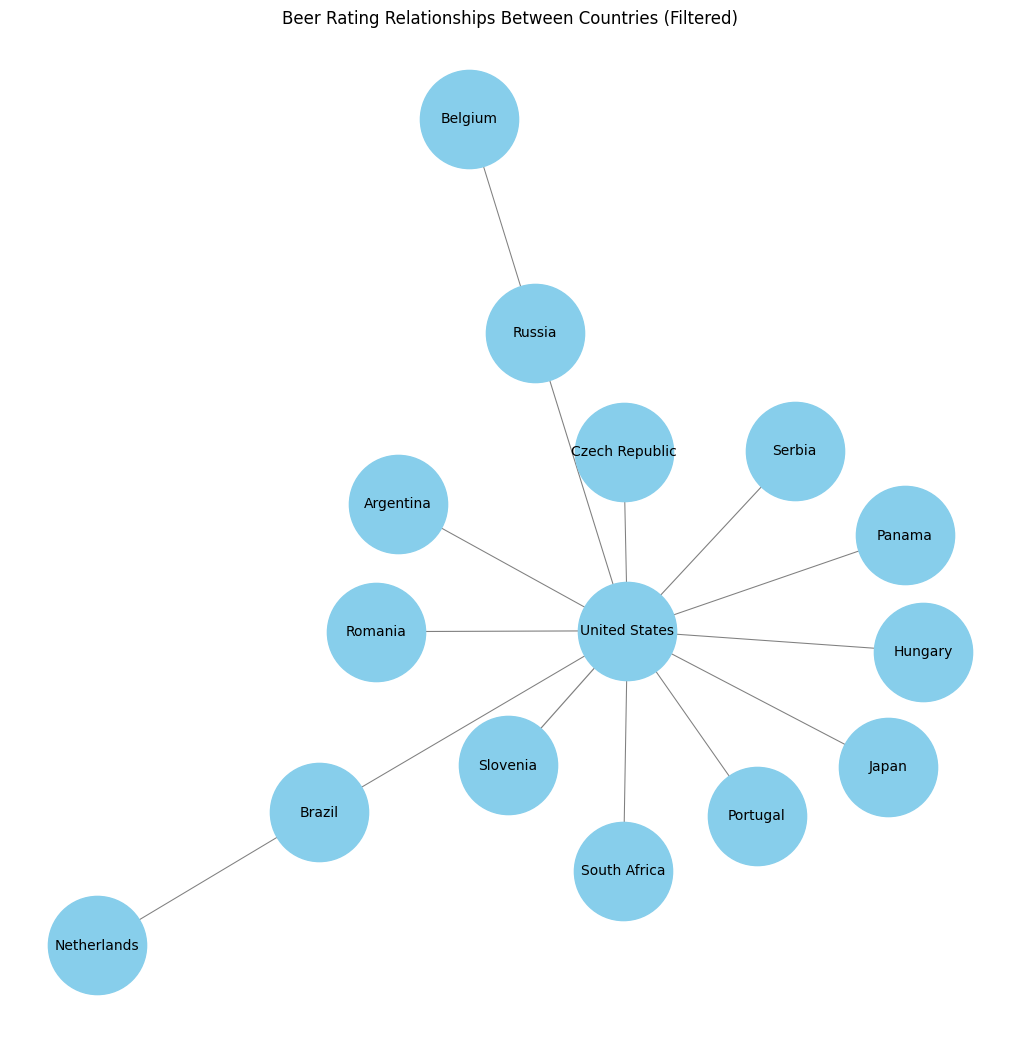

In [184]:
# Define a threshold for edge filtering based on average rating
threshold = 3.75  # Keep edges with an average rating above this value

# Filter edges by the threshold
filtered_edges = [(u, v) for u, v, d in G_filtered.edges(data=True) if d['weight'] > threshold]

# Create a filtered subgraph
filtered_graph = G_filtered.edge_subgraph(filtered_edges).copy()

# Visualization of the filtered graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(filtered_graph, k=0.1, iterations=100)
edges = filtered_graph.edges(data=True)
nx.draw(filtered_graph, pos, with_labels=True, node_color='skyblue', node_size=5000, edge_color='gray', width=[(d['weight']/5) for u, v, d in edges], font_size=10)
plt.title("Beer Rating Relationships Between Countries (Filtered)")
plt.show()



The network graph, with a high threshold of 3.75 for average beer ratings, indicates that the United States is the predominant node due to the American-centric nature of the data sources. The sparse connections between the U.S. and various countries suggest selective international appreciation for quality beers. Few inter-country connections outside the U.S. imply that there are isolated pockets of mutual beer enthusiasm rather than a widespread 'Beer Union' as we had imagined.

# Is there a domestic beer pride? Do users rate beers brewed in their home country better or worse?

People enjoy consuming and supporting domestic and especially local products, including beer, but does this introduce a bias towards their own country's beer? Lets simply the average ratings for domestic and international beers and compare.

In [126]:
# Filter out rows where 'user_location' or 'brewery_location' is 'nan' and create a copy
ratings_filtered = ratings.loc[(ratings['user_location'] != 'nan') & (ratings['brewery_location'] != 'nan')].copy()

# Add a new column categorizing each rating as domestic or international
ratings_filtered['rating_category'] = ['domestic' if user_loc == brew_loc else 'international'
                                       for user_loc, brew_loc in zip(ratings_filtered['user_location'], ratings_filtered['brewery_location'])]

# Calculate average ratings for domestic and international beers
average_ratings = ratings_filtered.groupby('rating_category')['rating'].mean()

# Compare the average ratings
domestic_rating = average_ratings.get('domestic', 0)
international_rating = average_ratings.get('international', 0)

print(f"Average domestic rating: {domestic_rating}")
print(f"Average international rating: {international_rating}")


Average domestic rating: 3.5005157775187987
Average international rating: 3.487596159330097


It seems that the average domestic rating is marginally higher than that of international rating. This is no surprise. But is this result even statistically significant? In order to answer this let's visuzalize the data and perform a Welch's t-test.

In [130]:
# Separate the ratings into two groups: domestic and international
domestic_ratings = ratings_filtered[ratings_filtered['rating_category'] == 'domestic']['rating']
international_ratings = ratings_filtered[ratings_filtered['rating_category'] == 'international']['rating']

# Perform the t-test
t_test_result = stats.ttest_ind(domestic_ratings, international_ratings, equal_var=False)  # Welch's t-test
print(t_test_result)


TtestResult(statistic=12.016049263109084, pvalue=2.938881595047869e-33, df=1232863.4615793305)


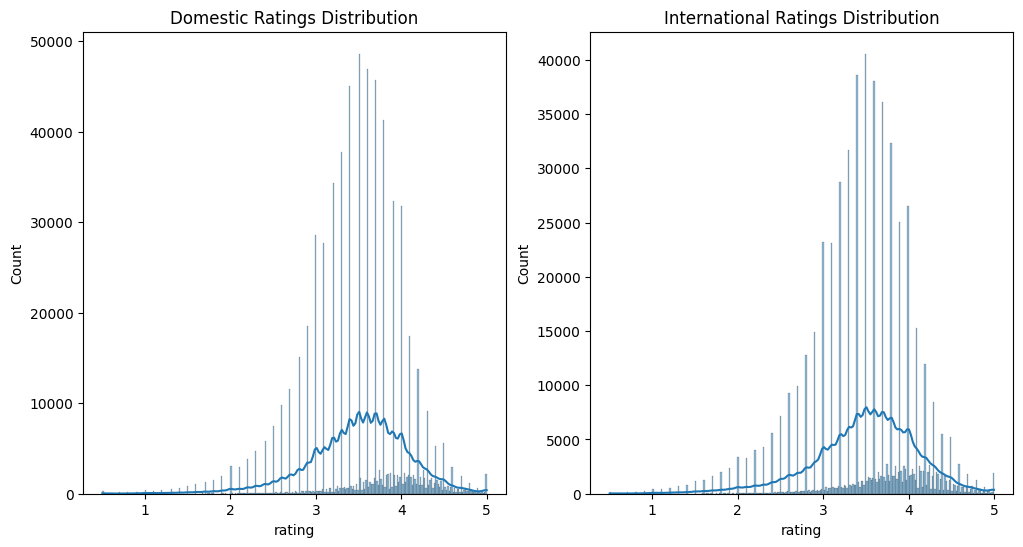

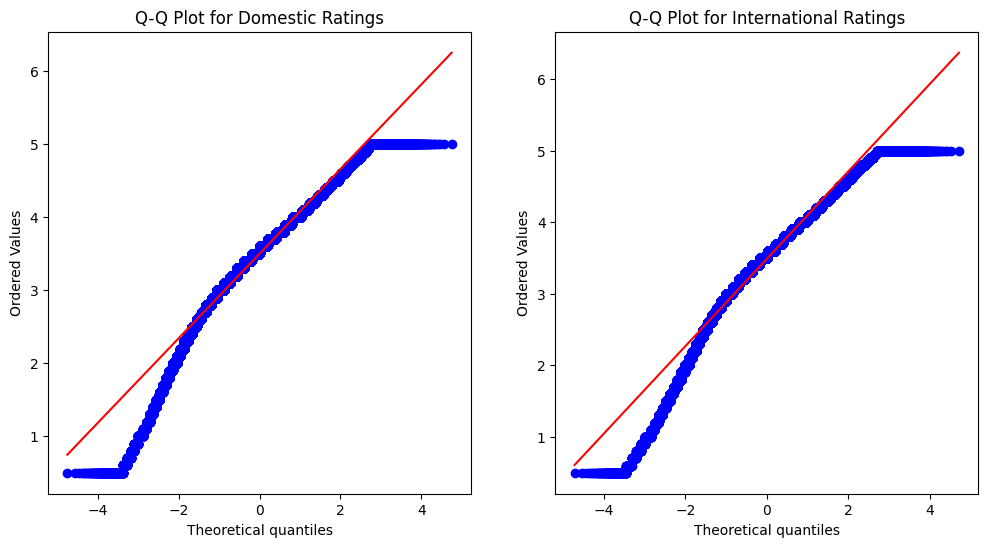

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograms for visual inspection of normality
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(domestic_ratings, kde=True)
plt.title('Domestic Ratings Distribution')

plt.subplot(1, 2, 2)
sns.histplot(international_ratings, kde=True)
plt.title('International Ratings Distribution')

plt.show()

# Q-Q Plots for normality check
import scipy.stats as stats

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(domestic_ratings, dist="norm", plot=plt)
plt.title('Q-Q Plot for Domestic Ratings')

plt.subplot(1, 2, 2)
stats.probplot(international_ratings, dist="norm", plot=plt)
plt.title('Q-Q Plot for International Ratings')

plt.show()


Given the large sample size and the robustness of Welch's t-test to violations of the equal variance and normality assumptions, the conclusion of a difference in ratings is statistically sound. 

# Question 3: Are beer reviewers the biggest bias?

In order to prove feasiblity, ratings_with_text_rb.txt file in the matched_beer_data is evaluated. This file is not in encoded in conventional excel format(s) which means that further processing is required to acheive the desired dataframe. 

We start by reading the data and rearranging it in order to get a comprehensive dataframe:

In [6]:
# read the ratings_with_text_rb.txt file in key:value format 
path_ = "C://Users//Parsa//Downloads//ada//data//matched_beer_data//ratings_with_text_rb.txt.gz"
read_data = pd.read_csv(path_, sep=":", header=None, names=["Key", "Value"], on_bad_lines='skip')

In [7]:
selected_col = read_data['Key'].unique()
df = pd.DataFrame(columns=selected_col)

# Create a dictionary to hold the series for each unique key
series_dict = {col: pd.Series(dtype=object) for col in selected_col}

# Populate the dictionary with values for each unique key
for col in selected_col:
    mask = read_data['Key'] == col
    series_dict[col] = read_data[mask]['Value'].reset_index(drop=True)

# create new DataFrame from the dictionary
df = pd.DataFrame(series_dict)

In [8]:
df.head(10)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1429178400,ciaranc,151109,3,7,2,8,17,3.70,"Bottle, gift from Aaron. Black, big head, lot..."
1,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1427796000,Rowlymo,198957,4,7,4,8,15,3.80,500ml Bottle in Bittles bar Belfast. Chocolat...
2,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1421665200,Don2711,285162,4,8,5,7,17,4.10,Great one and made very local to me. Bottle b...
3,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1380621600,genegenie,224156,5,8,3,5,19,4.00,"Deep roasted aroma, good dark brown/black col..."
4,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1371549600,kiwianer,88501,4,7,4,7,14,3.60,"The head is medium, the body black. It smells..."
5,Ards Bally Black Stout,155699,Ards Brewing Co.,13538,Stout,4.6,1321527600,Beersiveknown,128086,5,7,5,7,16,4.00,Cask@ Belfast beer fest. Dark brown black wit...
6,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1382436000,Beersiveknown,128086,4,7,4,5,13,3.30,"Bottle at Bittles Bar, BelfastHazy amber brow..."
7,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1371549600,kiwianer,88501,4,7,3,5,14,3.30,"The head is stable, the body golden, orange. ..."
8,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1385550000,genegenie,224156,5,8,4,9,18,4.40,Hard to find but worth it when you do. A refr...
9,Ards Pig Island Pale Ale,160664,Ards Brewing Co.,13538,Bitter,5.2,1339581600,visionthing,91324,4,7,4,7,14,3.60,"50cl bottle (4,8% ABV) at Bittles Bar, Belfas..."


We count the number of ratings per user to get an overview 

In [9]:
# the useful columns are kept and users with highest ranking are displayed

# only the user_name and rating columns are kept 
reviewer_rating = df[['user_name', 'rating']].copy()

# The rating values are transformed into numeric type for later processing 
reviewer_rating['rating'] = pd.to_numeric(reviewer_rating['rating'])

# The number of ratings are grouped by the user name 
num_reviews = reviewer_rating.groupby(['user_name']).size().reset_index(name='count').sort_values('count', ascending =False)
num_reviews.head(10)

,user_name,count
27486,yespr,5209
17337,fonefan,5160
11922,Ungstrup,4149
11750,Travlr,3819
13082,anders37,3732
19539,joergen,3241
21118,madmitch76,3229
22878,oh6gdx,3051
22953,omhper,2954
15103,cgarvieuk,2856


In [10]:
# filter out the reviewers with less than 50 reviews for statistical significance
num_reviews_filter = num_reviews[num_reviews['count'] > 50]

# Print out the pre and post filtering to get a notion of the number of filtered users 
print("Initial size: " + str(len(num_reviews)))
print("Size after filtering: " + str(len(num_reviews_filter)))

Initial size: 27674
Size after filtering: 3099


In the following section we take out a small subset of the top 10 users in terms of the number of 
reviews in order to get do a qualitative visual comparasion of their rating statistics:

In [11]:
#take the first N reviewers 
N = 10
top_reviewers = num_reviews_filter.head(N).user_name

# fetch rating data of pre-selectioned users 
df_top_reviewers = df.merge(right=top_reviewers, on=['user_name'], how='right')[['user_name', 'rating']]
df_top_reviewers['rating'] = pd.to_numeric(df_top_reviewers['rating']) 

In [12]:
# Sanity check for NaNs 
print("Number of NaNs in ratings: " + str(df_top_reviewers.rating.isna().sum()))

Number of NaNs in ratings: 0


Text(0.5, 1.0, '')

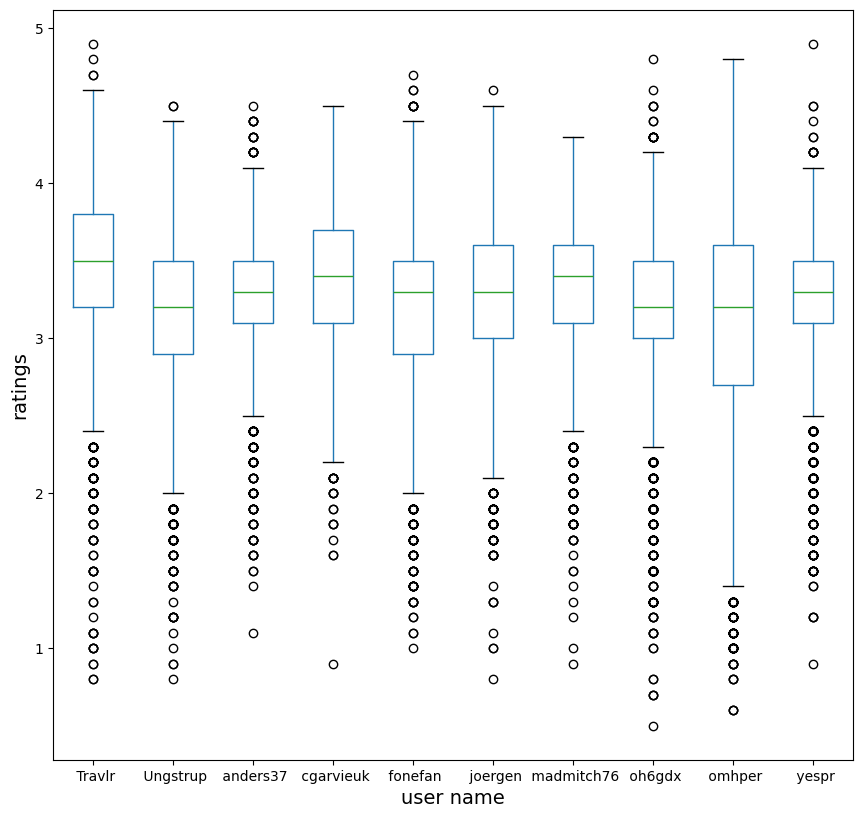

In [13]:
#Box plots displaying the distribution of scores of reviewers for qualitative comparasion  
bp = df_top_reviewers.boxplot(by='user_name', figsize=(10,10), grid=False, fontsize = 10)
bp.get_figure().suptitle('')
bp.set_ylabel('ratings', fontsize = 14)
bp.set_xlabel('user name', fontsize = 14)
bp.set_title('')


In the following section we define the threshold parameters for identifying "nice users": the users who consistently rate above a defined threshold. 

- This is done by firstly defining a rating threshold above which the ratings is considered "good". 
- We proceed by couting the number of "bad" ratings (below the rating threshold) finding the ration of  \frac{number of "bad" ratings}{total number of ratings} per user. 
- If this ratio is below a certain percentage, definded by percentage_threshold, the user is selected as a potential "nice user".  
- In the last step in order to discover if the user "consistently gives good ratings" we perform an ADF test to see if the rating data of the user identifies as a stationnary series. 
- The Null Hypothesis of the ADF test is that the time series is not stationnary, thus if the P value statistics is sufficiently small ( below the defined alpha threshold), the null hypothesis is rejected. 
- where applicable the user's user_name is added to the nice_users list.

In [14]:
# looking for users that consistently rate above threshold 

# rating threshold  
rating_threshold = 3

# The ratio of number of ratings below the threshold to the total number of ratings per user 
percentage_threshold = 0.15

# Used for P_value testing to verify if a series is stationary 
alpha = 0.05 

nice_users = []

# Take data of users with more than 50 ratings 
high_raters = pd.merge(reviewer_rating, num_reviews_filter, on='user_name')

# we count the number of ratings below the rating_threshold per user 
review_low_ratings = high_raters[high_raters['rating'] < rating_threshold].groupby('user_name').size().reset_index(name='low_count')

In [15]:
for member in review_low_ratings['user_name']:
    low_count = review_low_ratings[review_low_ratings['user_name'] == member].low_count.values[0]
    count = num_reviews_filter[num_reviews_filter['user_name'] == member].values[0][1]
    # percentage of low rating count to total rating count 
    low_percentage = low_count/count 
    
    if ( low_percentage <= percentage_threshold ):
        array_rating = high_raters[high_raters['user_name'] == member]['rating'].to_numpy()
        
        # ADF Score to find if the series is stationnary 
        p_value = adfuller(array_rating)[1]

        # null hyp: series is not stationnary which is violated if p_value <= alpha 
        if ( p_value <= alpha ):
            nice_users.append(member)
            

In [16]:
print("Number of detected Nice Users : "  + str(len(nice_users)))

Number of detected Nice Users : 1419


In the section below, the entimental information is extracted from the reviewer's text in a scale which would be comparable to the user ratings of the beers. As a proof of conecpt, the reviews of only one user is chosen to be anaylzed, since the method is extendable to the whole dataset. For this purpose BERT Mutilingual Sentimental Analysis pretrained model is used. This model is trained on wikipedia pages of 104 languages. The reason of this choice is to cover as many languages possible. For more information on BERT: https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment. By pure coincidence, the sentimental scale used by this classifier (0-5) is the same scale as the beer ratings, with the difference of being categorical. 

For a sanity check, we first take a small subset of the first 5 nice users form the nice_users list

In [22]:
# extract texts and ratings of useres with more than 50 reviews
#sample data for M users only 
red  = 5
nice_users_red = nice_users[:red]

# get rating and text data of the nice users 
text_from_reviewer = df[df['user_name'].isin(nice_users_red)][['user_name', 'rating', 'text']]

# drop the reviews without textual information
text_from_reviewer = text_from_reviewer[text_from_reviewer['text'].notna()]
top_user_names = text_from_reviewer['user_name'].unique()

print("Number of samples : " + str(len(text_from_reviewer)))
text_from_reviewer.head(10)

Number of samples : 1462


,user_name,rating,text
265,47574xeCD,3.50,"Bottle at bittlesCoffee, fruity dank hops, pi..."
4205,5000,3.20,Bouteille de 500 ml. ArÃ´mes surtout dominÃ©s...
6087,11026,3.00,"I donât know that this is a dunkel, Bushwak..."
6159,5000,3.30,On tap at Bushwakkers in Regina. Likely my f...
6164,1FastSTi,3.00,Drank at Bushwakkerâs in Regina. Appearanc...
6305,5000,3.50,"Wow, a fantastic porter. Lots of coffee in th..."
6313,1FastSTi,3.90,"Bottle, via trade from paco, shared with Park..."
12974,5000,3.60,"Brown , black tea like , small head . Medium ..."
19209,5000,3.50,Clear copper poor with a healthy foamy beige ...
34715,1FastSTi,1.60,Pours a clear pale straw color with a big whi...


In [23]:
# text preprocessing function to remove stopwords 
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in text.split() if word.lower() not in stop_words]
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', ' '.join(tokens))  
    return clean_text

We follow by preparing the pretrained sentimental analysis model 

In [24]:
# Load pre-trained model and tokenizer for multilingual sentiment analysis &  
# Create sentiment analysis pipeline

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"

# download the pretrained model 
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

# initilize autotokenizer for the pretrained model 
tokenizer = AutoTokenizer.from_pretrained(model_name, truncation=True)

#create pipeline for classification
sentiment_analysis = pipeline("sentiment-analysis", truncation=True, model=model, tokenizer=tokenizer)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [25]:
#remove stop words as well as invalid characters
cleaned_text_array = np.vectorize(preprocess_text)(text_from_reviewer['text'])

In [26]:
#Sentiment prediction 
results = np.vectorize(sentiment_analysis)(cleaned_text_array)

In [27]:
print(results[0])

[{'label': '5 stars', 'score': 0.7099984288215637}]


Add the new sentimental analysis based ratings with the confidence score to the user's 

In [28]:
sentiment_score = np.zeros((len(results), 2), dtype=float)

for i,r in enumerate(results):
    sentiment_score[i,0] = int(r[0]['label'].split()[0]) #extract the integer score
    sentiment_score[i,1] = r[0]['score']
        

For a visual check of the difference between the Sentimental rating and the actual rating of the users, their distributions are plotted as Violon plots.

In [29]:
# Violon plots to compare the difference of distributions of text predicted scores 
# and ratings of one reviewer

aug_reviewer_info = text_from_reviewer.copy()
aug_reviewer_info['pred_score'] = sentiment_score[:,0]
aug_reviewer_info['pred_accu.'] = sentiment_score[:,1]


# remove samples with an accuracy less than threshold_accu for noise reduction
threshold_accu = 0.40 
aug_reviewer_info = aug_reviewer_info[aug_reviewer_info['pred_accu.'] >= threshold_accu]

aug_reviewer_info.head()

,user_name,rating,text,pred_score,pred_accu.
265,47574xeCD,3.50,"Bottle at bittlesCoffee, fruity dank hops, pi...",5.0,0.709998
4205,5000,3.20,Bouteille de 500 ml. ArÃ´mes surtout dominÃ©s...,3.0,0.451697
6305,5000,3.50,"Wow, a fantastic porter. Lots of coffee in th...",5.0,0.789971
6313,1FastSTi,3.90,"Bottle, via trade from paco, shared with Park...",5.0,0.473637
12974,5000,3.60,"Brown , black tea like , small head . Medium ...",4.0,0.462877


C:\Users\Parsa\AppData\Local\Temp\ipykernel_21848\1070747570.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)
C:\Users\Parsa\AppData\Local\Temp\ipykernel_21848\1070747570.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)


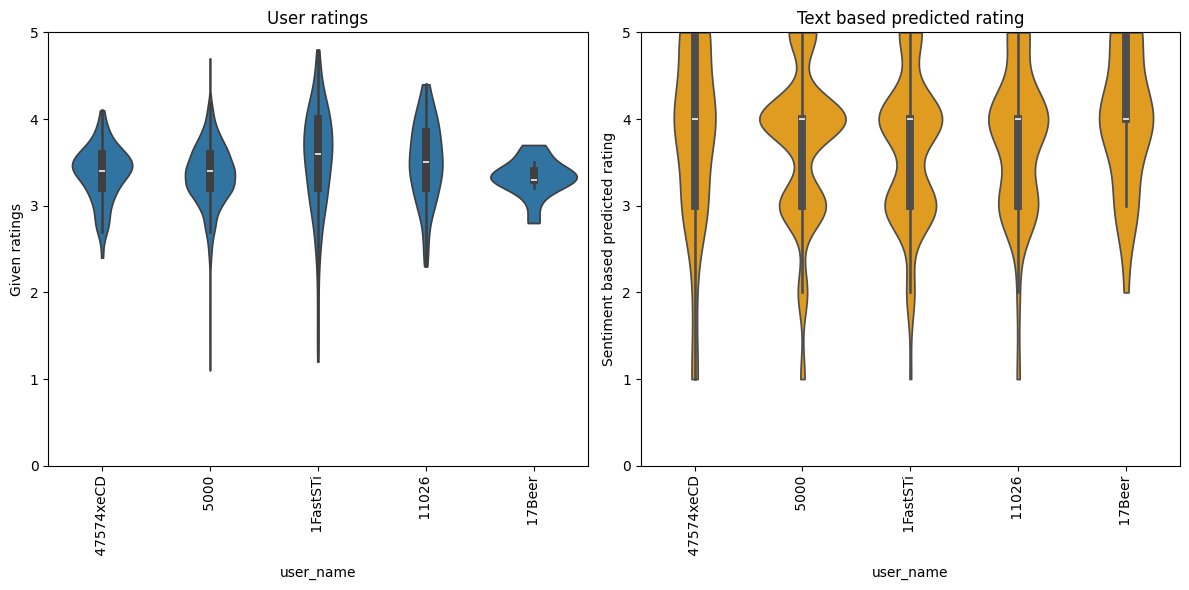

In [30]:
aug_reviewer_info = aug_reviewer_info.explode('rating')
aug_reviewer_info['rating'] = aug_reviewer_info['rating'].astype('float')

aug_reviewer_info = aug_reviewer_info.explode('pred_score')
aug_reviewer_info['pred_score'] = aug_reviewer_info['pred_score'].astype('float')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(data=aug_reviewer_info, x="user_name", y='rating', ax=axes[0], cut=0)
axes[0].set_title('User ratings')
axes[0].set_ylabel('Given ratings')
axes[0].set_ylim([0, 5])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)  

sns.violinplot(data=aug_reviewer_info, x="user_name", y='pred_score', ax=axes[1], cut=0, color = "orange")
axes[1].set_title('Text based predicted rating')
axes[1].set_ylabel('Sentiment based predicted rating')
axes[1].set_ylim([0, 5])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)  

plt.tight_layout()
plt.show()

Redifine the whole pipeline for every user in the nice users list 

In [31]:
# extract texts and ratings of useres with more than 50 reviews
# for the whole data set

text_from_reviewer = df[df['user_name'].isin(nice_users_red)][['user_name', 'rating', 'text']]
# drop the reviews without textual information
text_from_reviewer = text_from_reviewer[text_from_reviewer['text'].notna()]
top_user_names = text_from_reviewer['user_name'].unique()

print("Number of samples : " + str(len(text_from_reviewer)))

#remove stop words as well as invalid characters
cleaned_text_total = np.vectorize(preprocess_text)(text_from_reviewer['text'])

#Sentiment prediction 
results_total = np.vectorize(sentiment_analysis)(cleaned_text_total)

sentiment_score_total = np.zeros((len(results), 2), dtype=float)

for i,r in enumerate(results_total):
    sentiment_score_total[i,0] = int(r[0]['label'].split()[0]) #extract the integer score
    sentiment_score_total[i,1] = r[0]['score']

# Store results in a copy of the original dataframe
aug_reviewer_info = text_from_reviewer.copy()
aug_reviewer_info['pred_score'] = sentiment_score[:,0]
aug_reviewer_info['pred_accu.'] = sentiment_score[:,1] 

# remove samples with an accuracy less than threshold_accu
threshold_accu = 0.40 
aug_reviewer_info = aug_reviewer_info[aug_reviewer_info['pred_accu.'] >= threshold_accu]

Number of samples : 1462


A balancing metric is required to even out the inherent biases of the reviewers between putting down an actual score or writing their opininon in text. As displayed above this bias becomes apparent whilst comparing the ratings of a given reviewer with the perceived sentiment from their written review text. The *interpolated rating (ir)* can be expressed with the balancing formula as:

$$  ir_i = {rating_i*(1-\alpha) + sentiment\_rating_i*\alpha } $$

Where for a given user *ratings* represent the given score by the reviewer, *sentiment_rating* the sentimenal analysis score, *i* the index, and $\alpha\in[0,1]$ a balancing coefficient which has to be defined as below: 
    
- if the distributions of *ratings* & *sentiment_rating* are **close enough** $\alpha = 0.5$ 
- if the reviewer tends to **overrate** according to the *ratings* & *sentiment_rating* distribution differences  $  \alpha > 0.5$ 
- if the reviewer tends to **underrate** according to the *ratings* & *sentiment_rating* distribution differences  $  \alpha < 0.5$

In [2]:
aug_reviewer_info["ir"] = 0.5
for member in nice_users_red: 
    user_info = aug_reviewer_info[aug_reviewer_info['user_name'] == member][['rating', 'pred_score', 'pred_accu.', 'ir']]
    alpha = 0.5 - (user_info['rating'].mean() -  user_info['pred_score'].mean()) 
    ir = (user_info['rating']*(1-alpha) + user_info['pred_score']*alpha)
    aug_reviewer_info.loc[aug_reviewer_info['user_name'] == member, 'ir'] = ir


NameError: name 'aug_reviewer_info' is not defined

In [ ]:
aug_reviewer_info.head(10)